In [1]:
import xarray as xr
import numpy as np
from jax import config
config.update("jax_enable_x64", True)
from tqdm import tqdm
from jax import numpy as jnp
from diffrax import diffeqsolve, ODETerm, SemiImplicitEuler, SaveAt
from interpax import Interpolator2D
import equinox as eqx
import jax
import optax

In [2]:
flds = xr.open_dataset("./all-fields.nc")

In [3]:
flds

<xarray.Dataset>
Dimensions:    (t: 4000, x: 32)
Coordinates:
  * t          (t) float64 0.0 0.5 1.0 1.5 ... 1.998e+03 1.999e+03 2e+03
  * x          (x) float64 0.2641 0.7924 1.321 1.849 ... 15.05 15.58 16.11 16.64
Data variables:
    force-(x)  (t, x) float64 ...

In [4]:
xax = flds.coords["x"].data
tax = flds.coords["t"].data

dx = xax[1]-xax[0]
xmax = xax[-1] + dx/2.
dt = tax[1]-tax[0]

nv_part = 128
nx_part = xax.size

# initialize particles
xi = np.repeat(xax, nv_part)
vi = np.tile(np.linspace(-6, 6, nv_part), nx_part)

In [5]:
from matplotlib import pyplot as plt

Text(0, 0.5, 'v ($v_{th}$)')

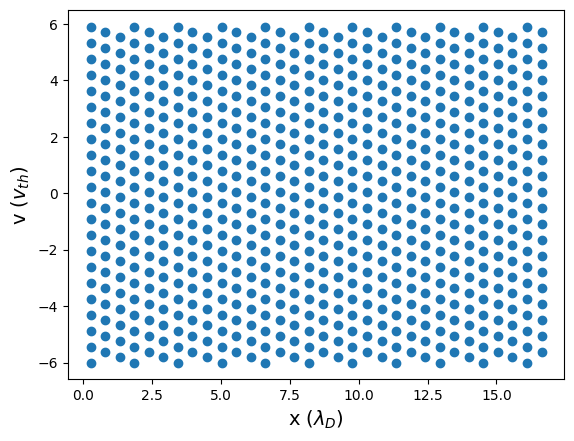

In [6]:
plt.scatter(xi[::6], vi[::6])
plt.xlabel("x ($\lambda_D$)", fontsize=14)
plt.ylabel("v ($v_{th}$)", fontsize=14)

In [7]:
nt = 2000
xp = np.zeros((nt, xi.size))
vp = np.zeros((nt, vi.size))

In [8]:
# padded_x = np.concatenate([xax[0:1]-dx, xax, xax[-1:]+dx])
# for it, tt in tqdm(enumerate(tax[:nt])):

#     # initialize (this should just be done outside the loop)
#     if it == 0:
#         xp[it] = xi + dt * vi
#         # padded_fld = np.concatenate([flds["force-(x)"][it].data[-1:], flds["force-(x)"][it].data, flds["force-(x)"][it].data[0:1]])
#         # fp = np.interp(xp[it], padded_x, padded_fld)
#         fp = np.interp(xp[it], xax, flds["force-(x)"][it].data, period=xmax)
#         vp[it] = vi + dt * fp
#     else:
#         xp[it] = xp[it-1] + dt * vp[it-1]
#         fp = np.interp(xp[it], xax, flds["force-(x)"][it].data, period=xmax)
#         # padded_fld = np.concatenate([flds["force-(x)"][it].data[-1:], flds["force-(x)"][it].data, flds["force-(x)"][it].data[0:1]])
#         # fp = np.interp(xp[it], padded_x, padded_fld)
#         vp[it] = vp[it-1] + dt * fp

#     # boundary condition
#     xp = np.where(xp > xmax, xp - xmax, np.where(xp < 0, xp + xmax, xp))

In [9]:
# def sample_trajectories(n_traj):
#     ipart = np.random.choice(np.arange(xi.size), n_traj, replace=False)
#     for ip in ipart:
#         plt.plot(vp[:, ip])
#     plt.grid()
#     plt.ylabel("v ($v_{th}$)", fontsize=14)
#     plt.xlabel("t ($\omega_p^{-1}$)", fontsize=14)
#     plt.title("Sample Velocity Trajectories", fontsize=16)
# sample_trajectories(16)

In [10]:
from equinox.internal import ω
import diffrax


class Leapfrog(SemiImplicitEuler):
    """Semi-implicit Euler's method.

    Symplectic method. Does not support adaptive step sizing. Uses 1st order local
    linear interpolation for dense/ts output.
    """

    def step(
        self,
        terms,
        t0,
        t1,
        y0,
        args,
        solver_state,
        made_jump,
    ):
        del solver_state, made_jump

        term_1, term_2 = terms
        y0_1, y0_2 = y0

        control1 = term_1.contr(t0, t1)
        control2 = term_2.contr(t0, t1)
        y1_1 = (y0_1**ω + term_1.vf_prod(t0, y0, args, control1)[0] ** ω).ω
        y1_1 = jnp.where(y1_1 > xmax, y1_1 - xmax, jnp.where(y1_1 < 0, y1_1 + xmax, y1_1))
        
        y1_2 = (y0_2**ω + term_2.vf_prod(t0, (y1_1, y0_2), args, control2)[0] ** ω).ω

        y1 = (y1_1, y1_2)
        dense_info = dict(y0=y0, y1=y1)
        return y1, None, dense_info, None, diffrax.RESULTS.successful


def dxdt(t, y, args):
    return y[1], y[1]

efield = Interpolator2D(tax, xax, flds["force-(x)"].data, method="linear", period=(None, xmax))

def dvdt(t, y, args):
    # it = (t/0.5).astype(jnp.int32)
    # print(it)
    # return jnp.interp(y[0], xax, args["e"][it], period=xmax)
    return efield(jnp.full_like(y[0], t), y[0]), y[1]

In [11]:
tmax = 2000
dt = 0.5
ground_truth = diffeqsolve((ODETerm(dxdt), ODETerm(dvdt)), solver=Leapfrog(), t0=0., t1=tmax, dt0=dt, y0=(xi, vi), 
                     args={"e": flds["force-(x)"].data}, 
                     saveat=SaveAt(ts=np.linspace(1, tmax-10, int(tmax//dt//2))))

In [12]:
ground_truth.ys[1].shape

(2000, 4096)

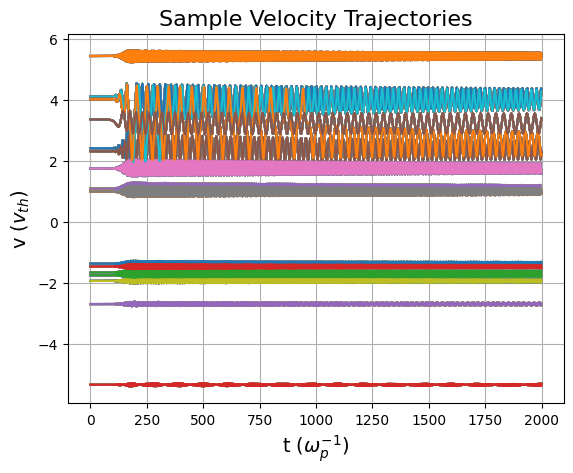

In [13]:
def sample_trajectories(n_traj):
    ipart = np.random.choice(np.arange(xi.size), n_traj, replace=False)
    for ip in ipart:
        # plt.plot(vp[:, ip])
        plt.plot(ground_truth.ys[1][:, ipart])
    plt.grid()
    plt.ylabel("v ($v_{th}$)", fontsize=14)
    plt.xlabel("t ($\omega_p^{-1}$)", fontsize=14)
    plt.title("Sample Velocity Trajectories", fontsize=16)
sample_trajectories(16)


In [14]:
# plt.plot(result.ts, result.ys[1][:, 96])
# plt.plot(tax[:2000], vp[:, 96])
# plt.xlim(500, 600)

In [62]:
class Hamiltonian(eqx.Module):
    ham_model: eqx.Module
    def __init__(self, model):
        self.ham_model = model
        self._dxdt_ = eqx.filter_vmap(jax.grad(self.ham_func, argnums=2))
        self._dvdt_ = eqx.filter_vmap(jax.grad(self.ham_func, argnums=1))
        
    def dxdt(self, t, y, args):
        __dxdt__ = self._dxdt_(jnp.full_like(xi, t), y[0], y[1])
        return __dxdt__, y[1]

    def dvdt(self, t, y, args):
        __dvdt__ = -self._dvdt_(jnp.full_like(xi, t), y[0], y[1])
        return __dvdt__, y[1]

    def ham_func(self, t, x, v):
        return jnp.squeeze(self.ham_model(jnp.array([t, x, v])))

ham_model = eqx.nn.MLP(3, 1, 8, 4, activation=jax.nn.tanh, key = jax.random.PRNGKey(42))

th = Hamiltonian(ham_model)

In [63]:
th.ham_func(20., xi[0], vi[0])

Array(-0.00398374, dtype=float64)

In [64]:
def integrate_ham(this_model):
    th = Hamiltonian(this_model)
    result = diffeqsolve((ODETerm(th.dxdt), ODETerm(th.dvdt)), solver=Leapfrog(), t0=0., t1=tmax, dt0=dt, y0=(xi, vi), 
                     saveat=SaveAt(ts=np.linspace(1, tmax-10, int(tmax//dt//2))))

    return result

def loss(this_ham):
    result = integrate_ham(this_ham)
    return jnp.mean(jnp.square(result.ys[1] - ground_truth.ys[1]))

In [65]:
result = integrate_ham(ham_model)

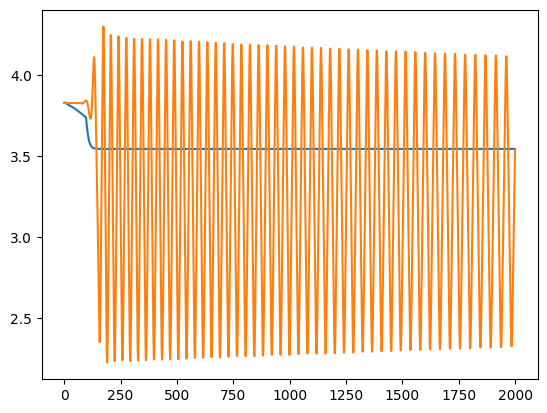

In [66]:
result = integrate_ham(ham_model)
plt.plot(result.ys[1][:, 104])
plt.plot(ground_truth.ys[1][:, 104])

In [72]:
params = ham_model
optim = optax.adam(1e-3)
opt_state = optim.init(eqx.filter(params, eqx.is_array))

for i in range(100):
    loss_value, grads = eqx.filter_jit(eqx.filter_value_and_grad(loss))(params)
    print(loss_value)
    updates, opt_state = optim.update(grads, opt_state)
    params = eqx.apply_updates(params, updates)
    

0.3684692743583018
0.3204305419967791
0.27899670120166875
0.24464570976222041
0.214813841355242
0.1909532406297145
0.1713685703032222
0.15495768626342254


KeyboardInterrupt: 

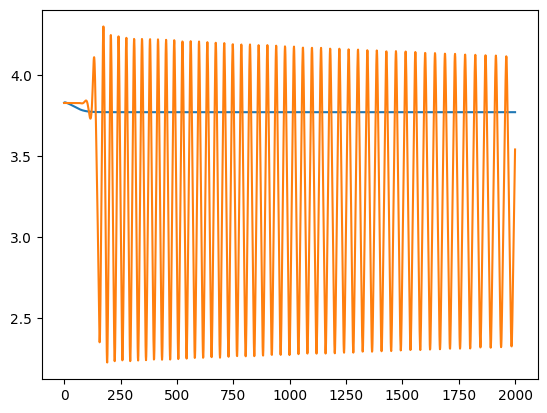

In [74]:
result = integrate_ham(params)
plt.plot(result.ys[1][:, 104])
plt.plot(ground_truth.ys[1][:, 104])